# Exam - 07/05/2024

## Excercise 1

 Nel file ````matrix-I.mat```` sono memorizzati  le matrici di due sistemi lineari:
 
    A  x = b 

    A1 x1 = b1
 
dove A, A1 sono le matrici dei coefficienti, b e b1 sono i termini noti, ed x ed x1 sono i vettori incogniti da determinare.

 - Verificare che per risolvere ciascuno dei due sistemi sia possibile utilizzare i due metodi di discesa (visti a lezione) ed il metodo di Gauss-Seidel, richiamando i risultati teorici opportuni.
 **Punti 1**
 - implementare i tre  algoritmi e  dire quante iterazioni richiede ciascuno di essi  per calcolare la soluzione con una toll=1e-6 e maxit=2000. Visualizzare in un grafico l'errore in scala logaritmica ad ogni iterazione per ciascuno dei due metodi. **Punti 7**
 - Analizzare l'indice di condizionamento delle due matrici e richiamare teoricamente cosa questo implica in termini della velocità di convergenza  dei tre metodi alla soluzione, richiamando i risultati teorici visti a lezione.**Punti 3**

[A] è quadrata? True
[A] è grande? Dimensione: 500
[A] è sparsa? True
[A] è simmetrica e definita positiva? True

[A1] è quadrata? True
[A1] è grande? Dimensione: 800
[A1] è sparsa? True
[A1] è simmetrica e definita positiva? True

raggio spettrale Gauss-Seidel  0.9749675725307556
[A] iterazioni Gauss-Seidel: 319
[A] iterazioni Steepest Descent: 1716
[A] iterazioni Gradiente Coniugato: 118


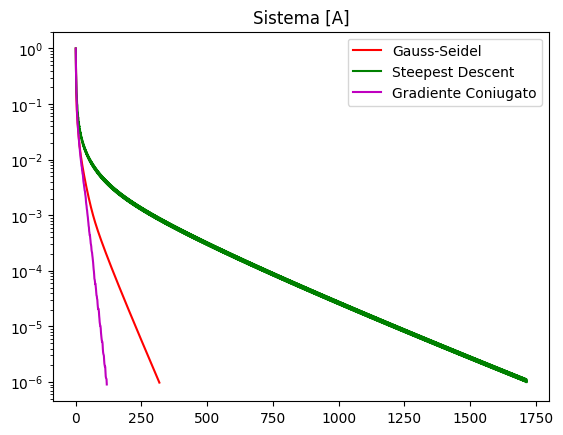

raggio spettrale Gauss-Seidel  0.5940256722011056
[A1] iterazioni Gauss-Seidel: 21
[A1] iterazioni Steepest Descent: 56
[A1] iterazioni Gradiente Coniugato: 21


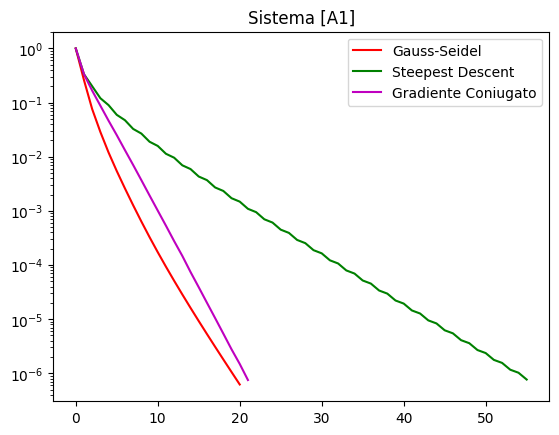

Condizionamento di [A]: 500.0000000000122
Condizionamento di [A1]: 10.00000000000026


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from SolveTriangular import *

dati = loadmat("./mat/matrix-I.mat")
A = dati["A"]
A = A.astype(float)
b = dati["b"]
b = b.astype(float)
A1 = dati["A1"]
A1 = A1.astype(float)
b1 = dati["b1"]
b1 = b1.astype(float)

# [Punto 1]
# Per applicare i 3 algoritmi, la matrice deve essere quadrata, inoltre deve essere grande e sparsa
# I 2 algoritmi di discesa del gradiente possono essere applicati solo se la matrice è simmetrica e definita positiva.
# Gauss-Seidel, invece, può essere applicato sia nel primo caso sia nel caso in cui sia a diagonale dominante.

# Se la matrice è simmetrica e definita positiva, risolvere il sistema associato equivale a trovare il minimo del funzionale quadratico.


def testMatriceQuadrata(A):
    return A.shape[0] == A.shape[1]


def isSparse(A):
    return np.count_nonzero(A) / A.size < 0.33


def isSimmetric(A):
    return np.allclose(A.T, A)


def isPositive(A):
    return isSimmetric(A) and np.all(np.linalg.eigvals(A) > 0)


print("[A] è quadrata?", testMatriceQuadrata(A))
print("[A] è grande? Dimensione:", A.shape[0])
print("[A] è sparsa?", isSparse(A))
print("[A] è simmetrica e definita positiva?", isPositive(A))

print("")

print("[A1] è quadrata?", testMatriceQuadrata(A1))
print("[A1] è grande? Dimensione:", A1.shape[0])
print("[A1] è sparsa?", isSparse(A1))
print("[A1] è simmetrica e definita positiva?", isPositive(A1))

print("")


# [Punto 2]
def gauss_seidel(A, b, x0, max_it=100, toll=1e-12):
    errore = 1000
    d = np.diag(A)
    D = np.diag(d)
    E = np.tril(A, -1)
    F = np.triu(A, 1)
    M = D + E
    N = -F
    invM = np.linalg.inv(M)
    T = invM @ N
    autovalori = np.linalg.eigvals(T)
    raggiospettrale = np.max(np.abs(autovalori))
    print("raggio spettrale Gauss-Seidel ", raggiospettrale)

    er = []
    while len(er) <= max_it and errore >= toll:
        x, flag = Lsolve(M, b - F @ x0)
        errore = np.linalg.norm(x - x0) / np.linalg.norm(x)
        er.append(errore)
        x0 = x.copy()

    return x, er, len(er)


def steepestdescent(A, b, x0, max_it=100, toll=1e-12):
    n, m = A.shape
    if n != m:
        print("Matrice non quadrata")
        return [], []

    x = x0.copy()
    r = b - A @ x
    it = 0
    nb = np.linalg.norm(b)
    errore = np.linalg.norm(r) / nb
    vec_sol = [x.copy()]
    vet_r = [errore]

    while errore >= toll and it < max_it:
        it += 1
        Ap = A @ r
        alpha = (r.T @ r) / (r.T @ Ap)
        x = x + alpha * r
        r = b - A @ x
        errore = np.linalg.norm(r) / nb
        vec_sol.append(x.copy())
        vet_r.append(errore)

    iterates_array = np.vstack([arr.T for arr in vec_sol])
    return x, vet_r, iterates_array, len(vet_r)


def conjugate_gradient(A, b, x0, max_it=100, toll=1e-12):
    n, m = A.shape
    if n != m:
        print("Matrice non quadrata")
        return [], []

    x = x0.copy()
    r = b - A @ x
    p = r.copy()
    it = 0
    nb = np.linalg.norm(b)
    errore = np.linalg.norm(r) / nb
    vec_sol = [x.copy()]
    vet_r = [errore]

    while errore >= toll and it < max_it:
        it += 1
        Ap = A @ p
        rtr = r.T @ r
        alpha = rtr / (p.T @ Ap)
        x = x + alpha * p
        r_new = r - alpha * Ap
        errore = np.linalg.norm(r_new) / nb
        vec_sol.append(x.copy())
        vet_r.append(errore)
        if errore < toll:
            break
        gamma = (r_new.T @ r_new) / rtr
        p = r_new + gamma * p
        r = r_new

    iterates_array = np.vstack([arr.T for arr in vec_sol])
    return x, vet_r, iterates_array, it


toll = 1e-6
maxit = 2000
x0 = np.zeros((b.size, 1))

x_gs, er_vet_gs, it_gs = gauss_seidel(A, b, x0, maxit, toll)
x_grads, vet_err_grads, vet_sol_grads, it_grads = steepestdescent(A, b, x0, maxit, toll)
x_gradc, vet_err_gradc, vet_sol_gradc, it_gradc = conjugate_gradient(
    A, b, x0, maxit, toll
)

print("[A] iterazioni Gauss-Seidel:", it_gs)
print("[A] iterazioni Steepest Descent:", it_grads)
print("[A] iterazioni Gradiente Coniugato:", it_gradc)

plt.title("Sistema [A]")
plt.semilogy(np.arange(it_gs), er_vet_gs, "r-")
plt.semilogy(np.arange(it_grads), vet_err_grads, "g-")
plt.semilogy(np.arange(it_gradc + 1), vet_err_gradc, "m-")
plt.legend(["Gauss-Seidel", "Steepest Descent", "Gradiente Coniugato"])
plt.show()

x0 = np.zeros((b1.size, 1))

x_gs, er_vet_gs, it_gs = gauss_seidel(A1, b1, x0, maxit, toll)
x_grads, vet_err_grads, vet_sol_grads, it_grads = steepestdescent(
    A1, b1, x0, maxit, toll
)
x_gradc, vet_err_gradc, vet_sol_gradc, it_gradc = conjugate_gradient(
    A1, b1, x0, maxit, toll
)

# print("Soluzione Gauss-Seidel:", x_gs[:4])
# print("Soluzione Steepest Descent:", x_grads[:4])
# print("Soluzione Gradiente Coniugato:", x_gradc[:4])

print("[A1] iterazioni Gauss-Seidel:", it_gs)
print("[A1] iterazioni Steepest Descent:", it_grads)
print("[A1] iterazioni Gradiente Coniugato:", it_gradc)

plt.title("Sistema [A1]")
plt.semilogy(np.arange(it_gs), er_vet_gs, "r-")
plt.semilogy(np.arange(it_grads), vet_err_grads, "g-")
plt.semilogy(np.arange(it_gradc + 1), vet_err_gradc, "m-")
plt.legend(["Gauss-Seidel", "Steepest Descent", "Gradiente Coniugato"])
plt.show()

# [Punto 3]
print("Condizionamento di [A]:", np.linalg.cond(A))
print("Condizionamento di [A1]:", np.linalg.cond(A1))

# Notiamo che Gradiente-Congiugato risolve entrambi i sistemi con meno iterazioni rispetto agli altri due algoritmi.
# Questo perché la velocità di convergenza del Gradiente-Coniugato dipende dalla radice del condizionamento "sqrt(A)",
# mentre Steepest-Descent dipende in maniera quadratica dal condizionamento (ovvero, un maggiore condizionamento influisce molto di più
# su Steepeset-Descent rispetto che su Gradiente-Coniugato).
# Per Gauss-Seidel è interessante osservare il raggio spettrale, che è molto vicino a 1.
# Più il raggio spettrale è vicino a 1, più la convergenza rallenta.
# Se si implementasse Gauss-Siedel-SOR con un opportuno omega, si osserverebbe il raggio spettrale avvicinarsi a 0 e, di conseguenza, la convergenza accelerare.

## Exercise  2

**Siano assegnati i punti del piano di coordinate $(x_i, y_i)$, $i=1,\ldots,3$ con**
$$
\begin{array}{c}
x_1=1, \quad x_2=4, \quad x_3=0, \\
y_1=1, \quad y_2=0, \quad y_3=4 .
\end{array}
$$ 
Scrivere lo script Python  in cui
- si costruisce il sistema lineare  ottenuto imponendo il passaggio della circonferenza di equazione $x^2+y^2+a_1x+a_2y+a_3=0$ per i tre punti assegnati, e si denotino con ${\bf M}$ e ${\bf b}$ la matrice dei coefficienti e il termine noto ottenuti;   [**punti 3**]

- si calcola la soluzione del sistema lineare ${\bf M}{\bf a}={\bf b}$ usando il metodo di fattorizzazione adatto alle caratteristiche della matrice $M$[**punti 2**]

- dopo averne determinato centro e raggio (vedi sotto formula), si rappresentino in una stessa figura la circonferenza di equazione $x^2+y^2+a_1x+a_2y+a_3=0$ (dove i coefficienti $a_i$ rappresentano la soluzione del sistema lineare del punto precedente) e i tre punti assegnati dal problema.[**punti 1**]
- Abbiamo costruito la circonferenza  ..**approssimante**.. i punti del piano
  [**punti 1**] 
  (completare al posto dei puntini)


Condizionamento di M: 10.403882032022066

Soluzione attesa: [[-7.]
 [-7.]
 [12.]]
Soluzione LU: [[-7.]
 [-7.]
 [12.]]


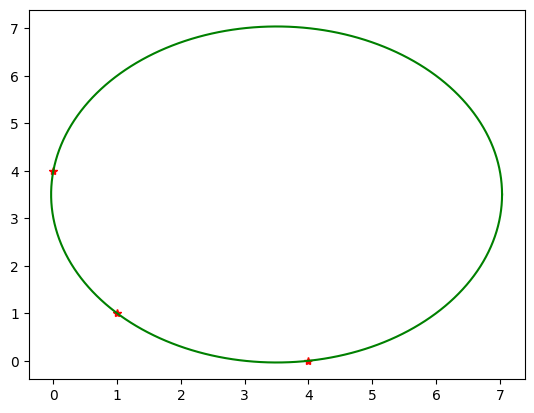

In [20]:
import scipy.linalg as spl

x = np.array([1, 4, 0, 5])
y = np.array([1, 0, 4, 6])

# [Punto 1]
# Sostituiamo x e y all'equazione della circonferenza (per ogni "i")
# [1] -> 1 + 1 + 1*a1 + 1*a2 + a3 = 0 ->  a1 + a2 + a3 = -2 
# [2] -> 16 + 4*a1 + a3 = 0           -> 4a1      + a3 = -16
# [3] -> 16 + 4*a2 + a3 = 0           ->      4a2 + a3 = -16

# Quindi:
M = np.array([
    [1, 1, 1],
    [4, 0, 1],
    [0, 4, 1]])

b = np.array([-2, -16, -16]).reshape(3, 1)

# [Punto 2]
print("Condizionamento di M:", np.linalg.cond(M))
print("")

x = np.linalg.solve(M, b)
print("Soluzione attesa:", x)

# La matrice è ben condizionata, quadrata, piccola e densa,
# ma non è simmetrica e def. pos., inoltre non è a diagonale dominante.
# Usiamo quindi la fattorizzazione LU di Gauss
PT, L, U = spl.lu(M)
P = PT.T
z, flag = Lsolve(L, P @ b)
if flag == 0:
    x, flag = Usolve(U, z)

print("Soluzione LU:", x)

# [Punto 3]
a1 = x[0]
a2 = x[1]
a3 = x[2]

cx = -a1 / 2
cy = -a2 / 2

r = np.sqrt((a1 * a1) / 4 + (a2 * a2) / 4 - a3)

funx = lambda t: cx + r * np.cos(t)
funy = lambda t: cy + r * np.sin(t)

tt = np.linspace(0, np.pi * 2, 200)

xx = funx(tt)
yy = funy(tt)

plt.plot(1, 1, "r*")
plt.plot(4, 0, "r*")
plt.plot(0, 4, "r*")
plt.plot(xx, yy, "g-")

plt.show()

**Siano assegnati i punti del piano di coordinate $(x_i, y_i)$, $i=1,\ldots,4$ con**
$$
\begin{array}{c}
x_1=1, \quad x_2=4, \quad x_3=0, \quad x_4=5 \\
y_1=1, \quad y_2=0, \quad y_3=4  \quad y_4=6.
\end{array}
$$ 
Scrivere lo script Python  in cui
- si costruisce il sistema lineare sovradeterminanto ottenuto imponendo il passaggio della circonferenza di equazione $x^2+y^2+a_1x+a_2y+a_3=0$ per i quattro punti assegnati, e si denotino con ${\bf A}$ e ${\bf c}$ la matrice dei coefficienti e il termine noto ottenuti;   [**punti 1**]

- si sfrutti la decomposizione QR  della matrice A  per ottenere la soluzione ${\bf a}^*$ del problema ai minimi quadrati $\min_{{\bf a} \in \mathbb{R}^3} \|{\bf A}{\bf a}-{\bf c}\|_2^2$  e  si calcoli il valore di $\|{\bf A}{\bf a}^*-{\bf c}\|_2^2$;   [**punti 5**]

-  dopo averne determinato centro e raggio, si rappresentino in una stessa figura la circonferenza di equazione $x^2+y^2+a^*_1x+a^*_2y+a^*_3=0$ (individuata dalla soluzione ${\bf a}^*$ del problema ai minimi quadrati) e i quattro punti assegnati dal problema.[**punti 1**]
-  
**Nota Bene**: Si ricorda che data una circonferenza nella forma canonica
$$ x^2+y^2+a_1 x+a_2 x+a_3=0$$

le coordinate del suo centro sono 
$$C≡(-a_1/2,-a_2/2)$$

e la lunghezza del suo raggio è data da:

$$r=\sqrt{\frac{a_1^2}{4}+\frac{a_2^2}{4} -a_3}$$

e la circoferenza può essere rappresentata in forma parametrica $C(t),  t \in [0, 2 \cdot \pi]$ e le due componenti parametriche sono $$x(t)= C_0+r\cdot cos(t);$$ $$ y(t)= C_1+r\cdot sin(t)$$


**Punti totali 14**

Condizionamento di M: 10.403882032022066

Soluzione QRLS (appros. ai minimi quadrati): [[-6.51401869]
 [-6.50333778]
 [10.41922563]]


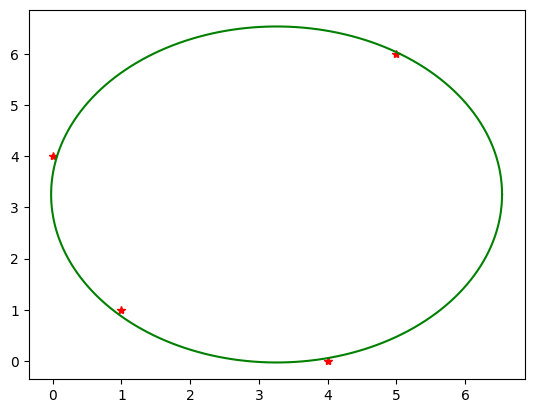

In [21]:
import scipy.linalg

x = np.array([1, 4, 0, 5])
y = np.array([1, 0, 4, 6])

# [Punto 1]
# Sostituiamo x e y all'equazione della circonferenza (per ogni "i")
# [1] -> 1 + 1 + 1*a1 + 1*a2 + a3 = 0   ->  a1 +  a2 + a3 = -2
# [2] -> 16 + 4*a1 + a3 = 0             -> 4a1       + a3 = -16
# [3] -> 16 + 4*a2 + a3 = 0             ->       4a2 + a3 = -16
# [4] -> 25 + 36 + 5*a1 + 6*a2 + a3 = 0 -> 5a1 + 6a2 + a3 = -61

A = np.array([[1, 1, 1], [4, 0, 1], [0, 4, 1], [5, 6, 1]])

c = np.array([-2, -16, -16, -61]).reshape(4, 1)

# [Punto 2]
print("Condizionamento di M:", np.linalg.cond(M))
print("")


def qrLS(A, b):
    n = A.shape[1]
    Q, R = scipy.linalg.qr(A)
    h = Q.T @ b
    x, _ = Usolve(R[0:n, :], h[0:n])

    return x, np.linalg.norm(h[n:]) ** 2


x, residuo = qrLS(A, c)
print("Soluzione QRLS (appros. ai minimi quadrati):", x)

# [Punto 3]
a1 = x[0]
a2 = x[1]
a3 = x[2]

cx = -a1 / 2
cy = -a2 / 2

r = np.sqrt((a1 * a1) / 4 + (a2 * a2) / 4 - a3)

funx = lambda t: cx + r * np.cos(t)
funy = lambda t: cy + r * np.sin(t)

tt = np.linspace(0, np.pi * 2, 200)

xx = funx(tt)
yy = funy(tt)

plt.plot(1, 1, "r*")
plt.plot(4, 0, "r*")
plt.plot(0, 4, "r*")
plt.plot(5, 6, "r*")
plt.plot(xx, yy, "g-")
plt.show()

## Domande Intelligenza Artificiale
**NB: Ogni risposta esatta:  +0.5 punti, ogni risposta errata: -0.5 punti. La mancanza di risposta:  0 punti**

**1** Quale delle seguenti affermazioni è FALSA riguardo alle reti MLP (Multilayer Perceptron)?
- Le reti MLP sono composte da uno o più strati nascosti di neuroni.
- Le reti MLP utilizzano una funzione di attivazione non lineare per introdurre una non linearità nel modello.
- Le reti MLP sono in grado di apprendere solo relazioni lineari tra i dati di input e output.
- Le reti MLP possono essere utilizzate per risolvere una vasta gamma di problemi di apprendimento automatico, tra cui la classificazione e la regressione.

In [22]:
# Risposta: PUNTO [**3**] 

**2.**  Quale delle seguenti affermazioni è la definizione CORRETTA di learning rate nel training di una rete neurale?
 - Il numero di volte in cui l'intero set di dati viene utilizzato durante il training.
 - Un parametro che controlla la velocità con cui i pesi della rete vengono aggiornati durante il training.
 - Il numero di neuroni presenti nello strato di output della rete.
 - La funzione di attivazione utilizzata dai neuroni della rete

In [23]:
# Risposta: PUNTO [**2**] 

**3.** Quale delle seguenti affermazioni è vera riguardo ai layer convoluzionali in una rete CNN?
- I layer convoluzionali applicano una funzione di attivazione a ciascun elemento della feature map in ingresso.
- I layer convoluzionali eseguono una convoluzione tra i filtri convoluzionali e la feature map in ingresso, producendo una nuova feature map.
- I layer convoluzionali riducono la dimensione spaziale della feature map in ingresso.
- I layer convoluzionali aumentano la dimensione spaziale della feature map in ingresso.

In [24]:
# Risposta: PUNTO [**2**] 

**4.**  
Quale tra le seguenti affermazioni descrive   il compito della funzione di attivazione nel training di una rete neurale?

- Trasformare i dati di input in un formato compatibile con la rete neurale

- Introdurre una non linearità nel flusso di informazioni della rete

- Calcolare l'errore tra l'output previsto e quello effettivo

- Aggiornare i pesi delle connessioni tra i neuroni softmax

Risposta: PUNTO [**2**]

In [25]:
# Risposta: PUNTO [**2**] 

**5.** Quale tra le seguenti affermazioni è FALSA riguardo alla suddivisione del dataset in un contesto di machine learning?

- La suddivisione del dataset in set di training, validation e test è fondamentale per valutare correttamente le prestazioni di un modello di machine learning.
- Il set di training viene utilizzato per addestrare il modello sui dati.
- Il set di validation viene utilizzato per trovare le etichette dei dati di input
- Il set di test viene utilizzato per valutare le prestazioni finali del modello su dati che non sono stati utilizzati per il training o la validation

In [26]:
# Risposta: PUNTO [**3**] 

# Domande aperte

**6. Descrivi in cosa consiste la fase di forward-propagation e back-propagation nell'ambito del training di una rete neurale, soffermandoti sull'importanza dell'algoritmo di backpropagation** per il calcolo delle derivate parziali della funzione costo rispetto ai pesi di tutti i layer **[punti 1.5]**

In [27]:
# Forward-propagation
# È la fase in cui i dati di input passano attraverso la rete neurale, strato per strato, per calcolare l'output finale. 
# Ogni neurone riceve un input, lo moltiplica per i pesi, aggiunge un bias e applica una funzione di attivazione (es. ReLU, sigmoid).

# Backward-propagation
# È la fase in cui si correggono i pesi della rete usando l’errore tra output previsto y^ e reale y
# Si calcolano le derivate della funzione costo rispetto ai pesi usando la regola della catena (derivata composta), 
# propagando l’errore dall’output verso l’input.

**7** Learning rate adattivo per ogni peso (durante il processo di ottimizzazione) : Adagrad, RMSProp, Adadelta, Adam. (formula di aggiornamento dei pesi e discussioni)
**[punti 3]**

In [28]:
# Durante l’addestramento, il learning rate determina quanto vengono modificati i pesi ad ogni passo. 
# I metodi adattivi regolano automaticamente il learning rate per ogni peso, rendendo l’ottimizzazione più stabile e veloce.

# Adagrad -> Adatta il learning rate a ogni parametro in base alla somma dei quadrati dei gradienti passati.
# vantaggi: utile per dati sparsi, svantaggi: il learning rate può diventare troppo piccolo

# RMSProp -> Modifica Adagrad mantenendo una media mobile dei gradienti.
# vantaggi: risolve il problema del learning rate che si annulla.

# Adadelta -> Variante di RMSProp che non richiede di fissare a priori il learning rate.
# vantaggi: più robusto non ce il bisogno di scegliere iperparametri

# Adam -> 
# vantaggi: adattivo per ogni peso è ottimo pre reti profonde.